# Survival Analysis of Different Drug Treatments

**Import Modules and set up dataframe using uis.csv dataset**

In [157]:
from lifelines import CoxPHFitter,KaplanMeierFitter
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from lifelines.plotting import plot_lifetimes as lplt


df = pd.read_csv('/Users/johnnyperez/Desktop/SQL JOB/Projects/PROJECT 5/uis.csv')

df_r = df.loc[:,["age","ndrugtx","treat","site","time","censor","herco"]]

**What the UIS Data Looks like**

In [149]:
df_r.head()

,age,ndrugtx,treat,site,time,censor,herco
0,39.0,1.0,1,0,188,1,3
1,33.0,8.0,1,0,26,1,3
2,33.0,3.0,1,0,207,1,2
3,32.0,1.0,0,0,144,1,3
4,24.0,5.0,1,0,551,0,2


The goal of the UIS data is to model time until return to drug use for patients enrolled in two different residential treatment programs that differed in length (treat=0 is the short program and treat=1 is the long program).  The patients were randomly assigned to two different sites (site=0 is site A and site=1 is site B).  The variable age indicates age at enrollment, herco indicates heroin or cocaine use in the past three months (herco=1 indicates heroin and cocaine use, herco=2 indicates either heroin or cocaine use and herco=3 indicates neither heroin nor cocaine use) and ndrugtx indicates the number of previous drug treatments.  The variables time contains the time until return to drug use and the censor variable indicates whether the subject returned to drug use (censor=1 indicates return to drug use and censor=0 otherwise).

**Varience in the Dataset**

In [156]:
categories = [i  for i in df_r.columns]

categories.remove('age')
categories.remove('time')
categories.remove('ndrugtx')

for cat in categories:
    print('Column Name: ',cat)
    print(df_r[cat].value_counts())
    print('-----------------------------')
    i+=1

Column Name:  treat
0    320
1    308
Name: treat, dtype: int64
-----------------------------
Column Name:  site
0    444
1    184
Name: site, dtype: int64
-----------------------------
Column Name:  censor
1    508
0    120
Name: censor, dtype: int64
-----------------------------
Column Name:  herco
1    289
3    225
2    114
Name: herco, dtype: int64
-----------------------------


**Univariate Analysis**

In survival analysis it is highly recommended to look at the Kaplan-Meier curves for all the categorical predictors. This will provide insight into the shape of the survival function for each group and give an idea of whether or not the groups are proportional (i.e. the survival functions are approximately parallel). 

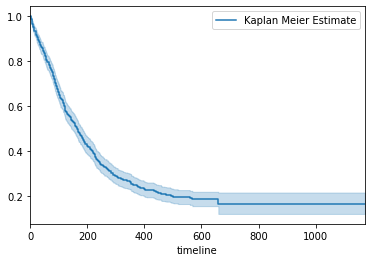

In [158]:
kmf = KaplanMeierFitter()
T = df_r['time']
C = df_r['censor']
kmf.fit(T,C,label='Kaplan Meier Estimate')
kmf.plot()

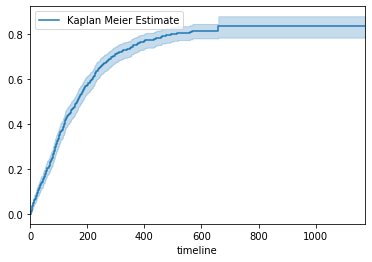

In [136]:
kmf.plot_cumulative_density()

In [139]:
pd.notna(df_dummy)

,age,ndrugtx,treat,site,time,censor,herco
0,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...
623,True,True,True,True,True,True,True
624,True,True,True,True,True,True,True
625,True,True,True,True,True,True,True
626,True,True,True,True,True,True,True


In [ ]:
from lifelines.plotting import plot_lifetimes

ax = plot_lifetimes(df_r['time'], event_observed=df_r[''])